C:\Users\xiaoy\AppData\Local\Temp\ipykernel_5260\2875451526.py:42: RuntimeWarning: divide by zero encountered in log
  return 2 * np.sum(np.where((x == 0) | (y == 0), 0, x * np.log(x / y)))
C:\Users\xiaoy\AppData\Local\Temp\ipykernel_5260\2875451526.py:42: RuntimeWarning: invalid value encountered in multiply
  return 2 * np.sum(np.where((x == 0) | (y == 0), 0, x * np.log(x / y)))
C:\Users\xiaoy\AppData\Local\Temp\ipykernel_5260\2875451526.py:42: RuntimeWarning: invalid value encountered in divide
  return 2 * np.sum(np.where((x == 0) | (y == 0), 0, x * np.log(x / y)))
C:\Users\xiaoy\AppData\Local\Temp\ipykernel_5260\2875451526.py:121: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_final_combined = linkage(final_combined_dist_matrix_filtered, method='complete')


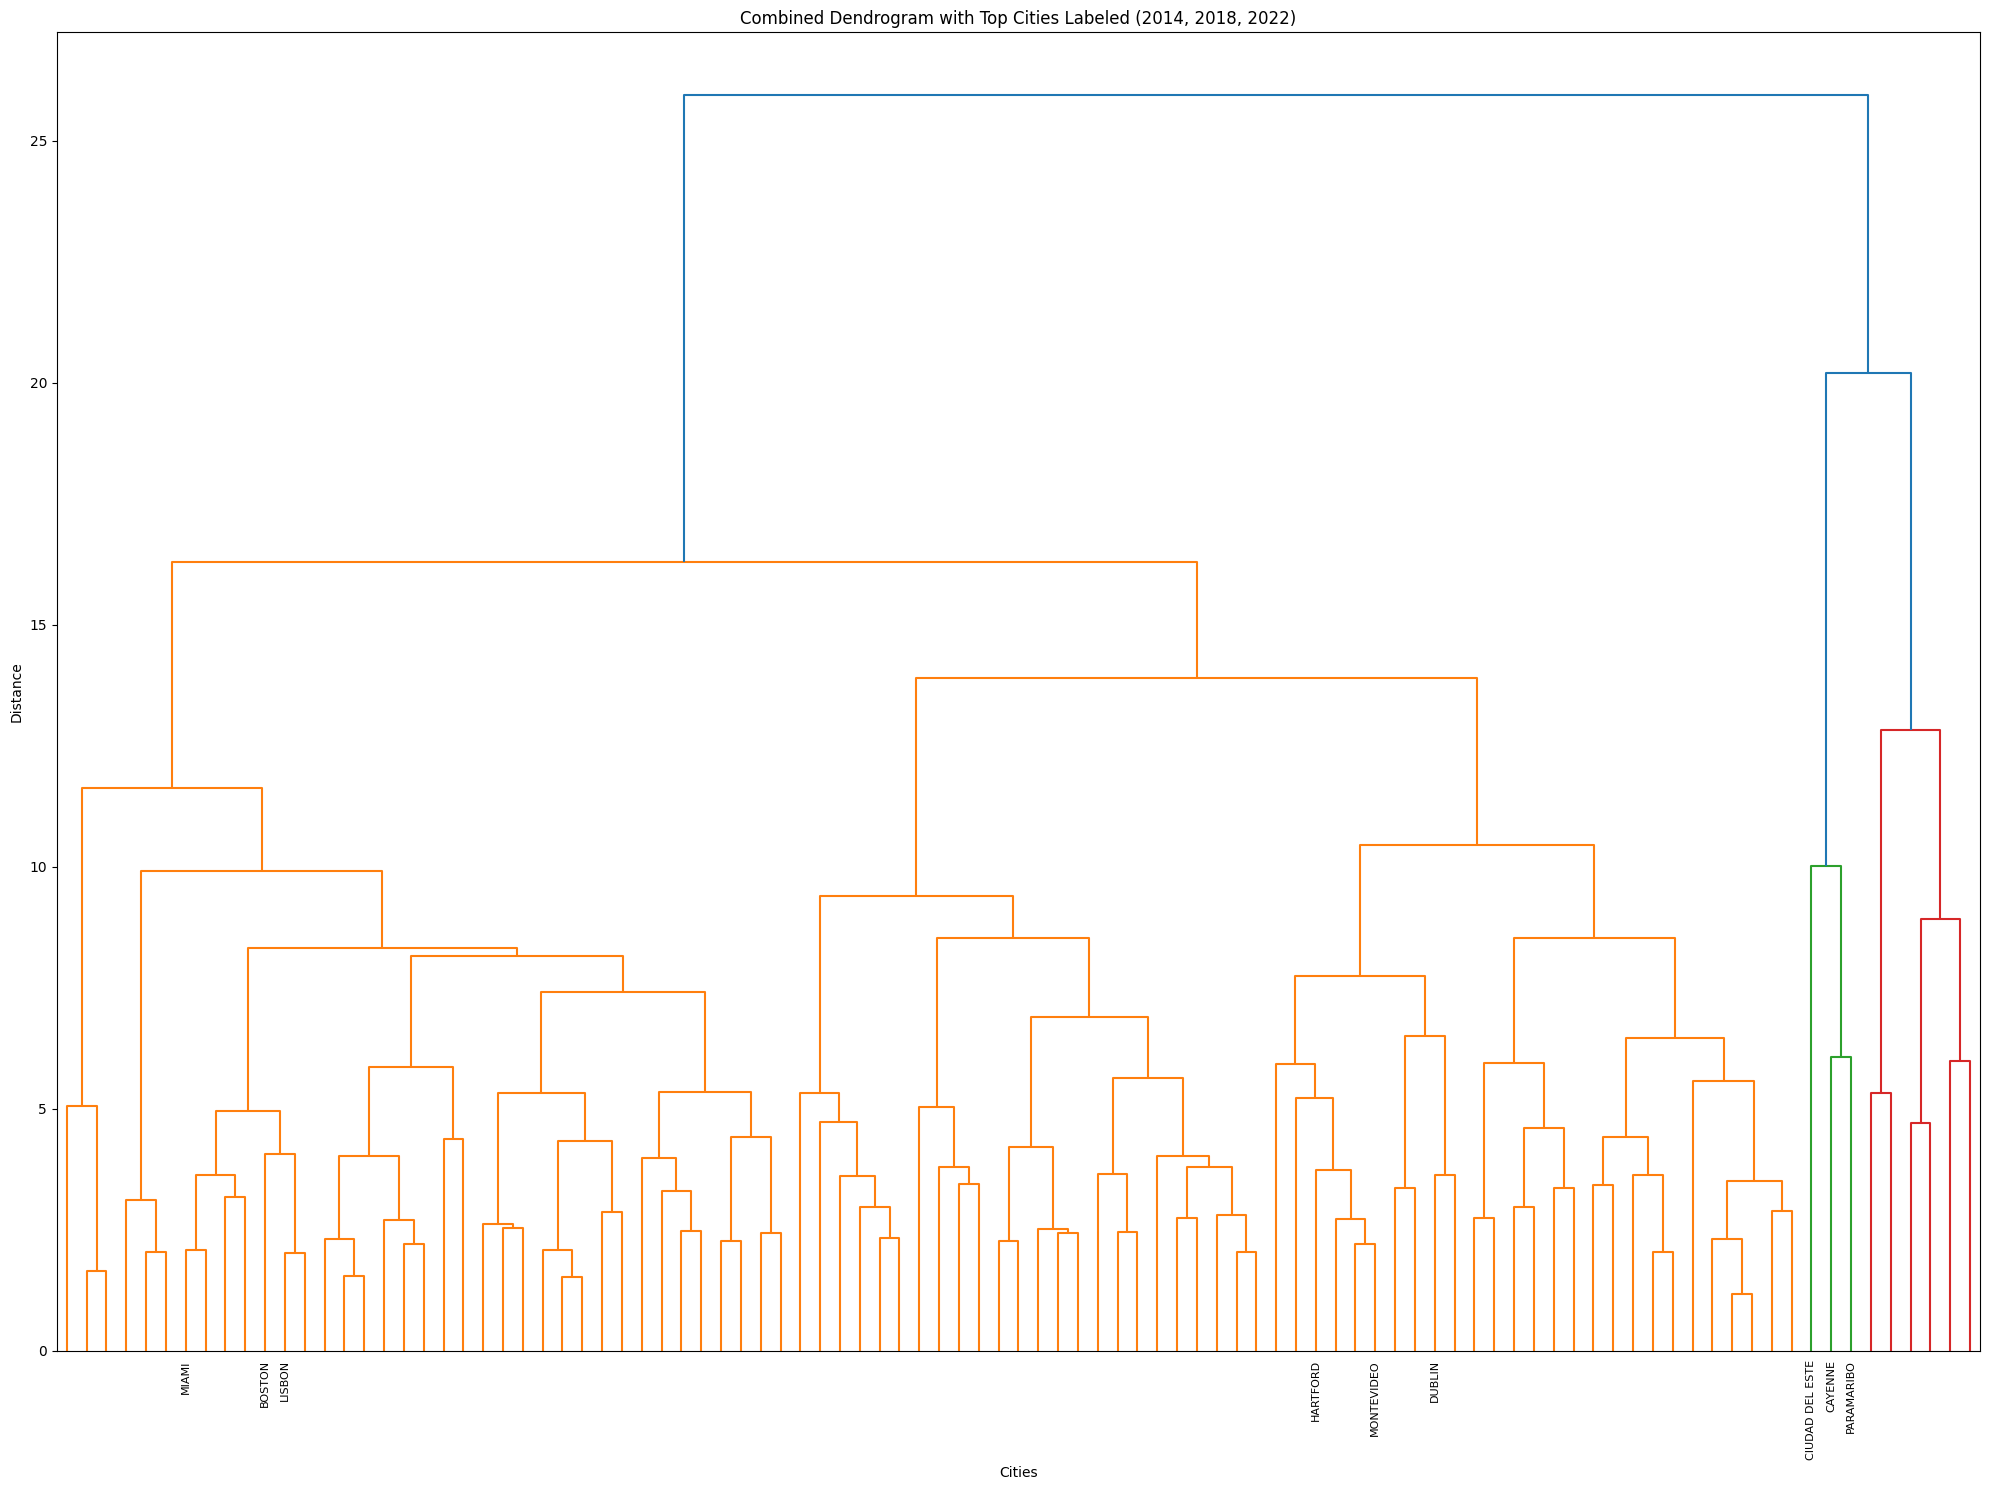

D:\python\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Cluster 1: ['ATLANTA', 'BARCELONA', 'BEIRUT', 'BERLIN', 'BOSTON', 'BRUSSELS', 'BUENOS AIRES', 'CHICAGO', 'FRANKFURT', 'GENEVA', 'HAMAMATSU', 'HOUSTON', 'LISBON', 'LONDON', 'LOS ANGELES', 'MADRID', 'MEXICO CITY', 'MIAMI', 'MILAN', 'MONTREAL', 'MUNICH', 'NAGOYA', 'NEW YORK', 'PARIS', 'PORTO', 'ROME', 'ROTTERDAM', 'SAN FRANCISCO', 'SANTIAGO', 'STOCKHOLM', 'SYDNEY', 'TOKYO', 'TORONTO', 'VANCOUVER', 'VIENNA', 'WASHINGTON', 'ZURICH'] (Total cities: 37)
Cluster 2: ['ABU DHABI', 'AMMAN', 'ASUNCION', 'BANGKOK', 'BEIJING', 'BOGOTA', 'BRATISLAVA', 'BUDAPEST', 'CAIRO', 'CAPE TOWN', 'CARACAS', 'COCHABAMBA', 'COPENHAGEN', 'CORDOBA', 'DOHA', 'DUBLIN', 'HARTFORD', 'HELSINKI', 'HONG KONG', 'ISTANBUL', 'JAKARTA', 'KUALA LUMPUR', 'LA PAZ', 'LIMA', 'LJUBLJANA', 'LUANDA', 'MANAGUA', 'MANILA', 'MAPUTO', 'MENDOZA', 'MONTEVIDEO', 'MOSCOW', 'OSLO', 'OTTAWA', 'PANAMA CITY', 'PORT OF SPAIN', 'PRAGUE', 'PRETORIA', 'QUITO', 'RIYADH', 'SAN JOSE', 'SAN SALVADOR', 'SANTA CRUZ DE LA SIERRA', 'SEOUL', 'SHANGHAI', 'SING

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns


# Load the datasets
file_path_2022 = 'Desktop/CLEANZZ22.csv'  # Adjust this path as needed
file_path_2014 = 'Desktop/CLEANZZ14.csv'
file_path_2018 = 'Desktop/CLEANZZ18.csv'

df_2022 = pd.read_csv(file_path_2022, encoding='ISO-8859-1')
df_2014 = pd.read_csv(file_path_2014, encoding='ISO-8859-1')
df_2018 = pd.read_csv(file_path_2018, encoding='ISO-8859-1')

# Function to create a long format dataframe
def create_long_format(df):
    return df.loc[df.index.repeat(df['NUMBER_OF_VOTERS_PROFILE'])]

# Function to create wide format dataframes for each category
def create_wide_format(df_long):
    df_wide_ms = df_long.pivot_table(index='CITY_NAME', columns='MARITAL_STATUS_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
    df_wide_gender = df_long.pivot_table(index='CITY_NAME', columns='GENDER_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
    df_wide_education = df_long.pivot_table(index='CITY_NAME', columns='EDUCATION_LEVEL_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
    df_wide_age = df_long.pivot_table(index='CITY_NAME', columns='AGE_GROUP_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
    return df_wide_ms, df_wide_gender, df_wide_education, df_wide_age

# Process 2022 data and filter cities
df_long_2022 = create_long_format(df_2022)
df_wide_ms_2022, df_wide_gender_2022, df_wide_education_2022, df_wide_age_2022 = create_wide_format(df_long_2022)
filtered_cities_2022 = df_wide_age_2022[df_wide_age_2022.sum(axis=1) >= 110].index

# Apply the same set of cities for 2014 and 2018 data
df_2014 = df_2014[df_2014['CITY_NAME'].isin(filtered_cities_2022)]
df_2018 = df_2018[df_2018['CITY_NAME'].isin(filtered_cities_2022)]
# Custom distance functions for categorical and ordinal data
def dev_multinom(x, y):
    # Kullback-Leibler divergence
    return 2 * np.sum(np.where((x == 0) | (y == 0), 0, x * np.log(x / y)))

def l2_dist(x, y):
    # L2 (Euclidean) distance
    return np.sum((x - y) ** 2)

def cat_dist(x, y, deviance=True, normalize=True):
    wx = np.sum(x)
    wy = np.sum(y)
    m = (x + y) / (wx + wy) # center
    x = x / wx
    y = y / wy
    D = dev_multinom if deviance else l2_dist
    if normalize:
        return np.sqrt(.5 * wx / (wx + wy) * D(x, m)) + np.sqrt(.5 * wy / (wx + wy) * D(y, m))
    else:
        return np.sqrt(.5 * wx * D(x, m)) + np.sqrt(.5 * wy * D(y, m))

def ord_dist(x, y, normalize=True,deviance=True):
    wx = np.sum(x)
    wy = np.sum(y)
    k = len(x) # should be equal to len(y)
    x = np.cumsum(x)[:-1]
    y = np.cumsum(y)[:-1]
    m = (x + y) / (wx + wy) # center
    x = x / wx
    y = y / wy
    if normalize:
        return np.sqrt(wx / (wx + wy) * l2_dist(x, m)) + np.sqrt(wy / (wx + wy) * l2_dist(y, m))
    else:
        return np.sqrt(wx * l2_dist(x, m)) + np.sqrt(wy * l2_dist(y, m))


# Process each year's data

df_long_2014 = create_long_format(df_2014)
df_wide_ms_2014, df_wide_gender_2014, df_wide_education_2014, df_wide_age_2014 = create_wide_format(df_long_2014)

df_long_2018 = create_long_format(df_2018)
df_wide_ms_2018, df_wide_gender_2018, df_wide_education_2018, df_wide_age_2018 = create_wide_format(df_long_2018)

# Ensure the same set of cities in the same order for all years
common_cities = set(df_wide_ms_2022.index) & set(df_wide_ms_2014.index) & set(df_wide_ms_2018.index)

def filter_common_cities(df_wide, common_cities):
    return df_wide.loc[df_wide.index.isin(common_cities)]

df_wide_ms_2022_filtered = filter_common_cities(df_wide_ms_2022, common_cities)
df_wide_gender_2022_filtered = filter_common_cities(df_wide_gender_2022, common_cities)
df_wide_education_2022_filtered = filter_common_cities(df_wide_education_2022, common_cities)
df_wide_age_2022_filtered = filter_common_cities(df_wide_age_2022, common_cities)

df_wide_ms_2014_filtered = filter_common_cities(df_wide_ms_2014, common_cities)
df_wide_gender_2014_filtered = filter_common_cities(df_wide_gender_2014, common_cities)
df_wide_education_2014_filtered = filter_common_cities(df_wide_education_2014, common_cities)
df_wide_age_2014_filtered = filter_common_cities(df_wide_age_2014, common_cities)

df_wide_ms_2018_filtered = filter_common_cities(df_wide_ms_2018, common_cities)
df_wide_gender_2018_filtered = filter_common_cities(df_wide_gender_2018, common_cities)
df_wide_education_2018_filtered = filter_common_cities(df_wide_education_2018, common_cities)
df_wide_age_2018_filtered = filter_common_cities(df_wide_age_2018, common_cities)

# Function to calculate combined distance matrix for each year
def calculate_combined_distance_matrix(df_wide_ms, df_wide_gender, df_wide_education, df_wide_age):
    dist_matrix_ms = squareform(pdist(df_wide_ms, metric=cat_dist))
    dist_matrix_gender = squareform(pdist(df_wide_gender, metric=cat_dist))
    dist_matrix_education = squareform(pdist(df_wide_education, metric=ord_dist))
    dist_matrix_age = squareform(pdist(df_wide_age, metric=ord_dist))
    return dist_matrix_ms + dist_matrix_gender + dist_matrix_education + dist_matrix_age

# Calculate combined distance matrices for each year
combined_dist_matrix_2022_filtered = calculate_combined_distance_matrix(df_wide_ms_2022_filtered, df_wide_gender_2022_filtered, df_wide_education_2022_filtered, df_wide_age_2022_filtered)
combined_dist_matrix_2014_filtered = calculate_combined_distance_matrix(df_wide_ms_2014_filtered, df_wide_gender_2014_filtered, df_wide_education_2014_filtered, df_wide_age_2014_filtered)
combined_dist_matrix_2018_filtered = calculate_combined_distance_matrix(df_wide_ms_2018_filtered, df_wide_gender_2018_filtered, df_wide_education_2018_filtered, df_wide_age_2018_filtered)

# Combine the distance matrices from 2014, 2018, and 2022 after filtering
final_combined_dist_matrix_filtered = combined_dist_matrix_2022_filtered + combined_dist_matrix_2014_filtered + combined_dist_matrix_2018_filtered

# Perform hierarchical clustering on the final combined distance matrix
Z_final_combined = linkage(final_combined_dist_matrix_filtered, method='complete')

# Using a distance threshold of 3900 to identify clusters
clusters = fcluster(Z_final_combined, t=15, criterion='distance')

# Creating a DataFrame to map cities to their clusters
cluster_mapping = pd.DataFrame({'City': df_wide_ms_2022_filtered.index, 'Cluster': clusters})


total_population = pd.concat([df_2022, df_2014, df_2018]).groupby('CITY_NAME').size()


cluster_mapping = cluster_mapping.join(total_population.rename('Total'), on='City')


top_cities = []
for cluster in [1, 2, 3]:  
    top_cities_cluster = cluster_mapping[cluster_mapping['Cluster'] == cluster].nlargest(3, 'Total')['City'].tolist()
    top_cities.extend(top_cities_cluster)
# Extracting the city names for highlighting in the dendrogram
highlighted_cities = top_cities

# Creating a label function to only show the top cities
def llf(id):
    if df_wide_ms_2022_filtered.index[id] in highlighted_cities:
        return df_wide_ms_2022_filtered.index[id]
    else:
        return ''

# Plotting the dendrogram with labels for top cities only
plt.figure(figsize=(20, 15))
dendrogram(Z_final_combined, labels=df_wide_ms_2022_filtered.index, leaf_label_func=llf, leaf_rotation=90, leaf_font_size=8)
plt.title("Combined Dendrogram with Top Cities Labeled (2014, 2018, 2022)")
plt.xlabel('Cities')
plt.ylabel('Distance')
plt.axhline(y=3900, color='r', linestyle='--')
plt.tight_layout()
plt.show()



# Extracting continent information
continent_info = df_2022.set_index('CITY_NAME')['CONTINENT']
continent_info_filtered = continent_info[continent_info.index.isin(common_cities)]

# Performing Multidimensional Scaling (MDS)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_result = mds.fit_transform(final_combined_dist_matrix_filtered)

# Extracting the MDS coordinates
mds_x = mds_result[:, 0]
mds_y = mds_result[:, 1]




top10_cities = total_population.nlargest(10).index

# Performing Multidimensional Scaling (MDS) using the same combined distance matrix as the dendrogram
mds_same_as_dendrogram = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_result_same_as_dendrogram = mds_same_as_dendrogram.fit_transform(final_combined_dist_matrix_filtered)

# Extracting the MDS coordinates
mds_x_same_as_dendrogram = mds_result_same_as_dendrogram[:, 0]
mds_y_same_as_dendrogram = mds_result_same_as_dendrogram[:, 1]

# Creating a scatter plot using the MDS results identical to the dendrogram's distance matrix
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('tab20', len(continent_info_filtered.unique()))

# Plotting all cities categorized by continent
for i, continent in enumerate(continent_info_filtered.unique()):
    idx = continent_info_filtered[continent_info_filtered == continent].index
    plt.scatter(
        mds_x_same_as_dendrogram[df_wide_ms_2022_filtered.index.isin(idx)], 
        mds_y_same_as_dendrogram[df_wide_ms_2022_filtered.index.isin(idx)], 
        label=continent, 
        color=cmap(i)
    )

# Highlighting top 10 cities by population
for city in top10_cities:
    if city in df_wide_ms_2022_filtered.index:
        city_index = df_wide_ms_2022_filtered.index.get_loc(city)
        plt.scatter(mds_x_same_as_dendrogram[city_index], mds_y_same_as_dendrogram[city_index], color='red', edgecolor='black', s=200)
        plt.text(mds_x_same_as_dendrogram[city_index], mds_y_same_as_dendrogram[city_index], city, fontsize=9)

plt.xlabel('MDS Dimension 1', fontsize=18)
plt.ylabel('MDS Dimension 2', fontsize=18)
plt.title('Scatter Plot of Cities by Continent (Aligned with Dendrogram)', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=10)

#plt.show()


scatter_plot_path = 'Desktop/plot.png'  
plt.savefig(scatter_plot_path)
plt.close()

# Re-generating the dendrogram with highlighted top cities for output
# Updating the label function to highlight New York in the dendrogram
def llf_updated(id):
    if df_wide_ms_2022_filtered.index[id] in highlighted_cities:
        return df_wide_ms_2022_filtered.index[id]
    elif df_wide_ms_2022_filtered.index[id] == "NEW YORK":
        return f"{df_wide_ms_2022_filtered.index[id]} "
    else:
        return ''

# Re-generating the dendrogram with New York highlighted
plt.figure(figsize=(20, 15))
dendrogram(
    Z_final_combined, 
    labels=df_wide_ms_2022_filtered.index, 
    leaf_label_func=llf_updated, 
    leaf_rotation=90, 
    leaf_font_size=12
)
plt.title("Combined Dendrogram with Top Cities and New York Labeled (2014, 2018, 2022)", fontsize=30)
plt.xlabel('Cities', fontsize=25)
plt.ylabel('Distance', fontsize=25)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=20)
plt.axhline(y=3900, color='r', linestyle='--')
plt.tight_layout()

#plt.show()

dendrogram_path = 'Desktop/combined_dendrogram.png'
plt.savefig(dendrogram_path)
plt.close()









# Counting the number of cities in each cluster
cluster_counts = cluster_mapping['Cluster'].value_counts()

# Identifying the top 3 clusters by the number of cities they contain
top_clusters = cluster_counts.head(3).index.tolist()

# Extracting cities for each of the top 3 clusters
cities_per_top_cluster = {
    cluster: cluster_mapping[cluster_mapping['Cluster'] == cluster]['City'].values 
    for cluster in top_clusters
}

# Creating a dictionary to store the typical voter profile for each cluster
typical_voter_profiles = {}

# Analyzing voter profiles for each of the top 3 clusters
for cluster, cities in cities_per_top_cluster.items():
    # Extracting data for cities in the current cluster
    df_cluster = df_2022[df_2022['CITY_NAME'].isin(cities)]

    # Calculating the mode (most common value) for each category in the cluster
    typical_profile = {
        'Most Common Marital Status': df_cluster['MARITAL_STATUS_CODE'].mode()[0],
        'Most Common Gender': df_cluster['GENDER_CODE'].mode()[0],
        'Most Common Education Level': df_cluster['EDUCATION_LEVEL_CODE'].mode()[0],
        'Most Common Age Group': df_cluster['AGE_GROUP_CODE'].mode()[0]
    }

    typical_voter_profiles[cluster] = typical_profile

# Mapping codes to their meanings
gender_code_map = {2: 'Male', 4: 'Female'}
marital_status_code_map = {1: 'Single', 3: 'Married', 5: 'Widowed', 7: 'Legally Separated', 9: 'Divorced'}
education_level_code_map = {1: 'Illiterate', 6: 'High School Graduate', 7: 'Incomplete College/University', 8: 'College/University Graduate'}
# Note: The education level for code 8 was assumed based on the context provided

# Updating the typical voter profiles with the actual meanings
typical_voter_profiles_interpreted = {}
for cluster, profile in typical_voter_profiles.items():
    interpreted_profile = {
        'Most Common Marital Status': marital_status_code_map[profile['Most Common Marital Status']],
        'Most Common Gender': gender_code_map[profile['Most Common Gender']],
        'Most Common Education Level': education_level_code_map.get(profile['Most Common Education Level'], "Unknown"),
        'Most Common Age Group': profile['Most Common Age Group']
    }
    typical_voter_profiles_interpreted[cluster] = interpreted_profile

typical_voter_profiles_interpreted


cities_in_clusters = {}
for cluster_number in set(clusters):
    cities = cluster_mapping[cluster_mapping['Cluster'] == cluster_number]['City'].tolist()
    cities_in_clusters[cluster_number] = cities

for cluster, cities in cities_in_clusters.items():
    num_cities = len(cities)
    print(f"Cluster {cluster}: {cities} (Total cities: {num_cities})")





clusters = cluster_mapping['Cluster'].unique()


for cluster in clusters:

    cluster_cities = cluster_mapping[cluster_mapping['Cluster'] == cluster]
    

    cluster_cities_sorted = cluster_cities.sort_values(by='Total', ascending=False)
    
   
    top_10_cities = cluster_cities_sorted.head(10)
    
 
    print(f"Cluster {cluster}:")
    for index, row in top_10_cities.iterrows():
        city_name = row['City']
        city_population = row['Total']
        print(f"{city_name}: {city_population}people")
    print("\n")








